# Comparing Proportional Selection and SUS Selection
In this notebook, I will compare the results of using proportional selection and SUS selection. 

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm

from leap_ec.algorithm import generational_ea
from leap_ec.individual import Individual
from leap_ec.representation import Representation
import leap_ec.ops as ops
from leap_ec import probe
from leap_ec.global_vars import context

from leap_ec.real_rep.problems import LangermannProblem
from leap_ec.real_rep.ops import mutate_gaussian
from leap_ec.real_rep.initializers import create_real_vector

## Define Parameters

In [2]:
MAX_GEN = 1000    # number of generations per iteration
POP_SIZE = 10     # population size
NUM_ITER = 100    # total number of iterations per selection operator
BOUNDS = [[0, 10]]*2  # bounds for LangermannProblem
CONFIDENCE = 0.99 # confidence interval for plot

## Run Proportional and Track Stats

In [3]:
prop_file = open('./proportional_stats.csv', 'w')
prop_stats_probe = probe.FitnessStatsCSVProbe(stream=prop_file, context=context)
for i in tqdm(range(NUM_ITER)):
    prop_stats_probe.bsf_ind = None
    ea = generational_ea(max_generations=MAX_GEN, pop_size=POP_SIZE,
                         problem=LangermannProblem(maximize=True),
                         representation=Representation(
                             initialize=create_real_vector(bounds=BOUNDS)
                         ),
                         pipeline=[
                             ops.proportional_selection(offset='pop-min'),
                             ops.clone,
                             ops.uniform_crossover,
                             mutate_gaussian(std=0.5, expected_num_mutations='isotropic'),
                             ops.evaluate,
                             ops.pool(size=POP_SIZE),
                             prop_stats_probe
                         ])
    list(ea);
prop_file.close()

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


## Run SUS and Track Stats

In [4]:
sus_file = open('./SUS_stats.csv', 'w')
sus_stats_probe = probe.FitnessStatsCSVProbe(stream=sus_file, context=context)
for i in tqdm(range(NUM_ITER)):
    sus_stats_probe.bsf_ind = None
    ea = generational_ea(max_generations=MAX_GEN, pop_size=POP_SIZE,
                         problem=LangermannProblem(maximize=True),
                         representation=Representation(
                             initialize=create_real_vector(bounds=BOUNDS)
                         ),
                         pipeline=[
                             ops.sus_selection(n=4, offset='pop-min'),
                             ops.clone,
                             ops.uniform_crossover,
                             mutate_gaussian(std=0.5, expected_num_mutations='isotropic'),
                             ops.evaluate,
                             ops.pool(size=POP_SIZE),
                             sus_stats_probe
                         ])
    list(ea);
sus_file.close()

100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


## Data Manipulation

In [5]:
import pandas as pd
from scipy import stats
import numpy as np

# read in data and calculate averages
prop_df = pd.read_csv('proportional_stats.csv')
sus_df = pd.read_csv('SUS_stats.csv')

prop_df_step = prop_df.groupby('step').mean()
sus_df_step = sus_df.groupby('step').mean()

sus_df_step.to_csv('SUS_avg_stats.csv')
prop_df_step.to_csv('prop_avg_stats.csv')

prop_bsf = prop_df_step[' bsf'].values
sus_bsf = sus_df_step[' bsf'].values

## Compute Confidence Intervals

In [6]:
# create lists to store +/- (up/down) confidence intervals for each generation
prop_conf_up = []
prop_conf_down = []
sus_conf_up = []
sus_conf_down = []
for i in range(MAX_GEN):
    prop_step_data = prop_df[prop_df['step'] == i][' bsf'].values
    sus_step_data = sus_df[sus_df['step'] == i][' bsf'].values
    prop_int_up, prop_int_down = stats.t.interval(CONFIDENCE, len(prop_step_data)-1, loc=prop_bsf[i], scale=stats.sem(prop_step_data)) 
    sus_int_up, sus_int_down = stats.t.interval(CONFIDENCE, len(sus_step_data)-1, loc=sus_bsf[i], scale=stats.sem(sus_step_data))
    prop_conf_up.append(prop_int_up)
    prop_conf_down.append(prop_int_down)
    sus_conf_up.append(sus_int_up)
    sus_conf_down.append(sus_int_down)
    
print(prop_conf_up[0:10])
print(prop_conf_down[0:10])
print(sus_conf_up[0:10])
print(sus_conf_down[0:10])

[1.0891042443895338, 1.396948906707644, 1.6564447895478973, 1.7768397425450693, 1.9472799775371366, 1.9870764805865346, 2.0997995692098494, 2.164089274890242, 2.224185059502523, 2.236928885467731]
[1.6169937781526853, 1.9198493618905152, 2.1818052111506847, 2.322094604436615, 2.4713493798088733, 2.5116464582011786, 2.6253639999604395, 2.6997517376450872, 2.754381594931125, 2.7738371736329563]
[1.380197934047494, 1.828628036400697, 1.9418529049063762, 2.0681035585024743, 2.1802538344892626, 2.3063316901448587, 2.3968923168167025, 2.4424399731880193, 2.5077817700486578, 2.5311401307668753]
[1.9612168067095799, 2.3552383617097568, 2.481137910504679, 2.6098854787858743, 2.7095483620407435, 2.821175128381115, 2.9020316585472776, 2.9589044437929326, 3.0270587086017273, 3.0448285692055315]


## Plot Result

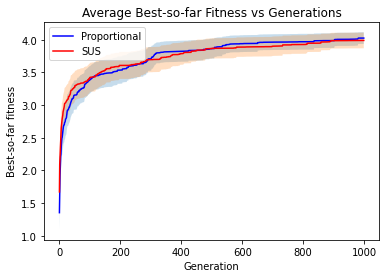

In [7]:
steps = list(range(MAX_GEN))
plt.plot(steps, prop_bsf, color='blue', label='Proportional')
plt.fill_between(steps, prop_conf_up, prop_conf_down, alpha=0.25)
plt.plot(steps, sus_bsf, color='red', label='SUS')
plt.fill_between(steps, sus_conf_up, sus_conf_down, alpha=0.25)
plt.legend()
plt.ylabel('Best-so-far fitness')
plt.xlabel('Generation')
plt.title('Average Best-so-far Fitness vs Generations')
plt.savefig(f'prop_vs_sus_bsf_conf{CONFIDENCE}_langermann.png')

plt.show()
